## 计算香农熵 ##

In [3]:
from math import log
import operator
%matplotlib inline
#计算给定数据集的香农熵
def calcShannonEnt(dataSet):
    numEntries=len(dataSet)
    labelCount={}
    for featVec in dataSet:
        #数据集的最后一列存储标签
        currentLabel=featVec[-1]
        if currentLabel not in labelCount.keys():
            labelCount[currentLabel]=0
        labelCount[currentLabel]+=1
    shannonEnt=0.0
    for key in labelCount:
        prob=float(labelCount[key])/numEntries
        shannonEnt-=prob*log(prob,2)
    return shannonEnt
#创建自己的数据集
def createDataSet():
    dataSet=[
        [1,1,'yes'],
        [1,1,'yes'],
        [1,0,'no'],
        [0,1,'no'],
        [0,1,'no']
    ]
    labels=['no surfacing','flippers']
    return dataSet,labels
#查看数据 并计算香农熵
myDat,labels=createDataSet()
print(myDat)
print(calcShannonEnt(myDat))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
0.9709505944546686


## 新增一个maybe的分类，查看熵的变化 ##

In [5]:
myDat[0][-1]='maybe'
print(myDat)
print(calcShannonEnt(myDat))

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
1.3709505944546687


## 划分数据集 ##

In [7]:
myDat[0][-1]='yes'
#按照特定特征划分数据集
#返回axis特征上 所有值为value的数据样本
def splitDataSet(dataSet,axis,value):
    retDataSet=[]
    for featVect in dataSet:
        #print(featVect[axis],value)
        if featVect[axis] == value:
            reducedFeatVec=featVect[:axis]
            #print(reducedFeatVec)
            reducedFeatVec.extend(featVect[axis+1:]) #把axis列特征去掉 剩下的存入列表
            #print(reducedFeatVec)
            retDataSet.append(reducedFeatVec)
            #print(retDataSet)
    return retDataSet
print(splitDataSet(myDat,0,1))

[[1, 'yes'], [1, 'yes'], [0, 'no']]


## 选择最好的数据集划分方式 ##

In [9]:
#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures=len(dataSet[0])-1

    baseEntropy=calcShannonEnt(dataSet)
    bestInfoGain=0.0
    bestFeature=-1
    for i in range(numFeatures):
        #创建唯一的分类标签列表
        featList=[example[i] for example in dataSet]
        uniqueVals=set(featList)
        newEntropy=0.0
        #计算每种特征分的信息熵
        for value in uniqueVals:
            subDataSet=splitDataSet(dataSet,i,value)
            prob=len(subDataSet)/float(len(dataSet))
            newEntropy+=prob*calcShannonEnt(subDataSet)
        infoGain=baseEntropy-newEntropy
        #计算最高的信息增益
        if(infoGain > bestInfoGain):
            bestInfoGain=infoGain
            bestFeature=i
    return bestFeature
print(chooseBestFeatureToSplit(myDat))
print(myDat)

0
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


## 多数表决投票法 ##

In [10]:
#返回次数最多的分类名称
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
        sortedClassCount=sorted(classCount.items(),
                                key=operator.itemgetter(1),reverse=True)
        return sortedClassCount[0][0]

## 创建树的代码##

In [11]:
def createTree(dataSet,labels):
    classList=[example[-1] for example in dataSet]
    #如果类别完全相同 停止继续划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    #如果feature使用完 则返回出现次数最多的类别
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat=chooseBestFeatureToSplit(dataSet)
    bestFeatLabel=labels[bestFeat]
    #初始化树
    myTree={bestFeatLabel:{}}
    del(labels[bestFeat])
    #得到最高的属性 含有几种可能的取值
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    for value in uniqueVals:
        subLabels=labels[:]
        myTree[bestFeatLabel][value]=createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree
myTree=createTree(myDat,labels)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


##  python绘制树节点##

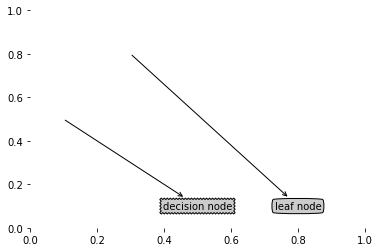

In [12]:
import matplotlib.pyplot as plt
#定义文本款和箭头格式
decisionNode=dict(boxstyle="sawtooth",fc="0.8")
leafNode=dict(boxstyle="round4",fc="0.8")
arrow_args=dict(arrowstyle="<-")
#使用文本注解绘制树节点
#绘制带箭头的注解
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',
                            va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)
def createPlot():
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.ax1=plt.subplot(111,frameon=False)
    plotNode('decision node',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('leaf node',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()
createPlot()

## 获取叶节点的数目和树的层数 ##

In [14]:
#获取叶节点的数目
def getNumLeafs(myTree):
    numLeafs=0
    #firstStr=myTree.keys()[0]
    firstStr=myTree.keys()
    firstStr=list(firstStr)[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else:
            numLeafs+=1
    return numLeafs
#计算树的深度
def getTreeDepth(myTree):
    maxDepth=0
    #firstStr=myTree.keys()[0]
    #python3 使用list转换firststr，原书使用[0]只能用于python2
    firstStr = myTree.keys()
    firstStr = list(firstStr)[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else:
            thisDepth=1
        if thisDepth>maxDepth:
            maxDepth=thisDepth
    return maxDepth
#手动创建一个树
def retrieveTree(i):
    listOfTrees=[{'no surfacing':{0:'no',1:{'flippers':
                                                {0:'no',1:'yes'}
    }}},
                 {'no surfacing':{0:'no',1:{'flippers':
                                                {0:{'head':{0:'no',1:'yes'}},1:'no'}}}}
                 ]
    return listOfTrees[i]
myTree=retrieveTree(0)
print(getNumLeafs(myTree))
print(getTreeDepth(myTree))

3
2


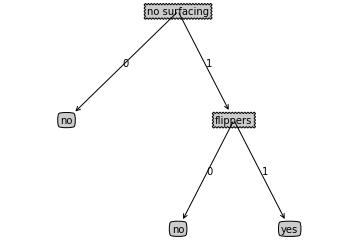

In [15]:
#在父子节点间填充文本信息
def plotMidText(cntrPt,parentPt,txtString):
    xMid=(parentPt[0]-cntrPt[0])/2.0+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2.0+cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs=getNumLeafs(myTree)
    depth=getTreeDepth(myTree)
    firstStr=myTree.keys()
    firstStr=list(firstStr)[0]
    cntrPt=(plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW,
            plotTree.yOff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=myTree[firstStr]
    plotTree.yOff=plotTree.yOff-1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff=plotTree.yOff+1.0/plotTree.totalD
def createPlot(inTree):
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.xOff=-0.5/plotTree.totalW
    plotTree.yOff=1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()
createPlot(myTree)

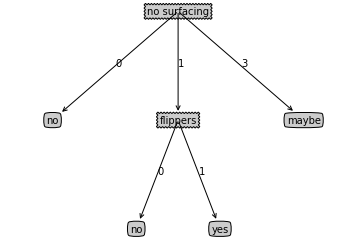

In [16]:
##myTree['no surfacing'][3]='maybe'
createPlot(myTree)

In [17]:
#使用决策树的分类函数
def classify(inputTree,featLabels,testVec):
    firstStr=inputTree.keys()
    firstStr=list(firstStr)[0]
    secondDict=inputTree[firstStr]
    featIndex=featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel=classify(secondDict[key],featLabels,testVec)
            else:
                classLabel=secondDict[key]
    return classLabel
myDat,labels=createDataSet()
print(labels)
myTree=retrieveTree(0)
print(myTree)
print(classify(myTree,labels,[1,0]))
print(classify(myTree,labels,[1,1]))

['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no
yes


## 决策树的存储 ##

In [18]:
#使用picle模块存储决策树
#这边按照书上就会有问题 需要在存储和读出的时候加上b选项 二进制存储
def storeTree(inputTree,filename):
    import pickle
    with open(filename, 'wb') as fp:
        pickle.dump(inputTree, fp)
def grabTree(filename):
    import pickle
    fr = open(filename,'rb')
    return pickle.load(fr)

## 使用决策树预测隐形眼睛类型 ##

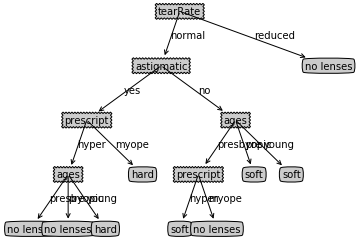

In [20]:
fr=open('lenses.txt')
lenses=[inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels=['ages','prescript','astigmatic','tearRate']
lensesTree=createTree(lenses,lensesLabels)
createPlot(lensesTree)